# Reinforcement learning for Electric Grid Optimization
### Reinforcement Learning Final Project | Author: Richard-John Lin, Xiangyue Wang

## Introduction

In order to limit global warming to 1.5 degree Celcius and prevent climate catastrophe, cities and states must rapidly shift toward clean energy. Fundamental to the global decarbonization effort is the need to have clean electricity. Renewable energy sources such as solar and wind are volatile due to their dependence on weather, therefore grid operators need new solutions to ensure electric grid stability without relying on fossil fuel generators. For our final project, we apply reinforcement learning to electric grid optimization with the goal of helping grid operators navigate a grid that rely on clean sources. 

### Environment

**Environment**: is a modeling of the "world" in which the *agent* takes some *actions* to achieve some pre-definite objectives. For our environment, we used Grid2Op, which is a python library developed by the French electric company RTE that simulate power system in reinforcement learning framework. In essence, a power grid connects generators (producers) to loads (consumers). Specifically, we used a simulated power network from the 2022 Learn to Run a Power Network competition (L2RPN) consisting of 186 powerlines, 118 substations, and 7 batteries. More importantly, the grid relies almost exclusively on clean electric sources consisting of solar, wind, nuclear, and hydro.

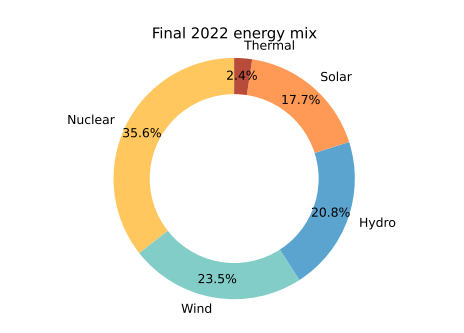

To start, let's install the environment.

In [1]:
#pip install grid2op

## State Observation

**State** / **Observation**: is the (partial) view of the environment as seen by the Agent. The Agent receives a new state after each action it takes. It can use the observation (state) at time step *t* to take an action at time *t*. The state includes the physical network, which consists of load, generator status, line connection status, and thermal limit of each line. Let's try a small example:


In [2]:
import grid2op

# To plot the graphs
import matplotlib.pyplot as plt
from grid2op.PlotGrid import PlotMatplot 

import warnings
warnings.filterwarnings('ignore')

# Set the environment as a small grid consisting of 5 substations.
env = grid2op.make("rte_case5_example", test=True)

TLet's plot the layout of the grid to get an initial idea. his could be done using the function PlotMatplot from grid2op.

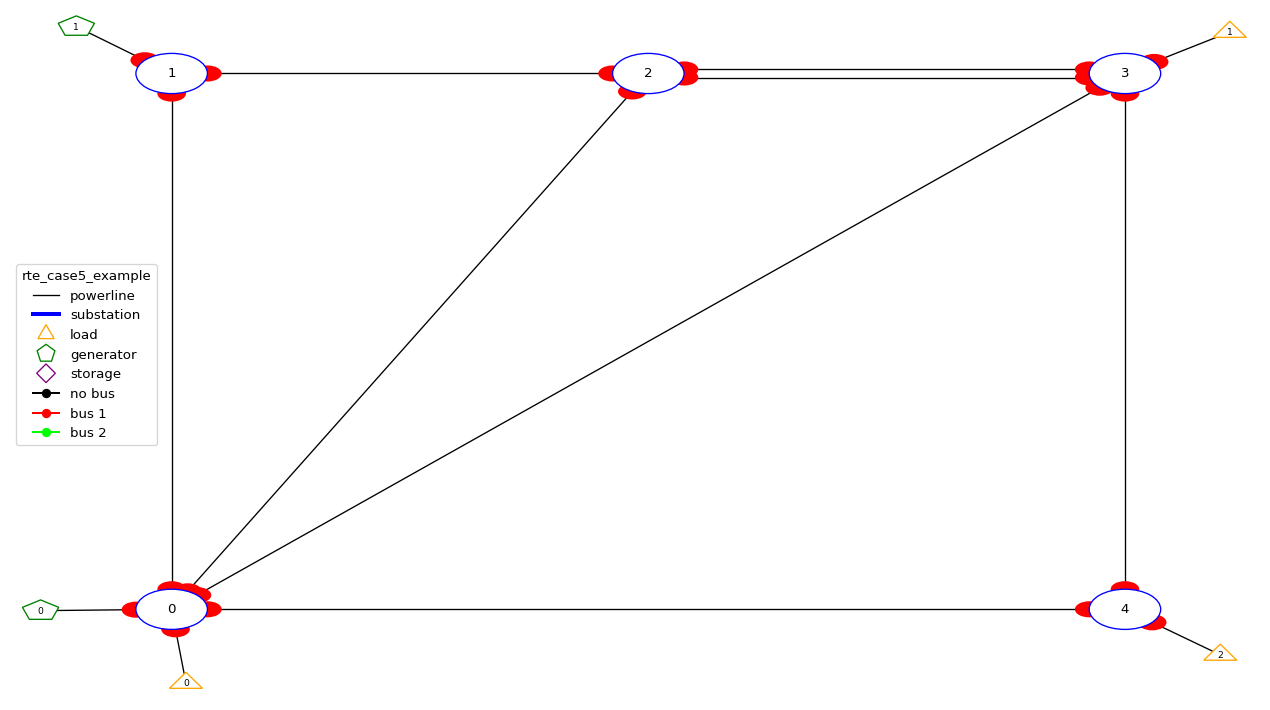

In [3]:
plot = PlotMatplot(env.observation_space)
fig = plot.plot_layout()

In the above figure you can see  :
- Substations represented as circles, you can see five on this figure, labelled 0, 1, ..., 4.
- Powerlines showed with lines on this plot, you can see eight powerlines there.
- Generators displayed with pentagons, there are two.
- Nodes represented as solid circles, which are points where two or more electrical components are connected.
- Loads displayed with small orange cirle, three on this simple powergrid.


Furthermore, the state includes the amount of electricity flowing on each power line at the given time, and the amount of electricity that is supplied to and withdraw from the power network by generators, loads and batteries. Naturally, the powergrid will not only be modified by the agent but also by the environment (for example, the load can increase because lots of people are getting home and start heating their appartment). To generate the input and output electricity, the environment contain data about the weather and the electric consumption.


### Action

**Action**: is an information sent by the Agent that will modify the internal state of the environment. The RL agent can change:
* Line status (line connection/disconnection).
* Topology (node splitting).
* Power production changes/curtailment (of generators), the specificality of which depends on the generators. For example, wind and solar can only be curtailed. 
* Storage changes (storage or delivery from batteries). 
* Nothing.

For line status operations, the agent acts using the substations, which are circles shown in the previous example. A more detailed representation looks like this:

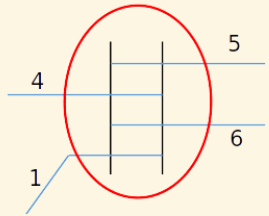

The Agent can choose to connect any pair of the four powerlines together using the two bars, which are known as buses.

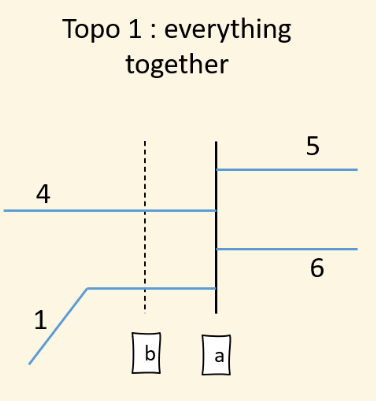
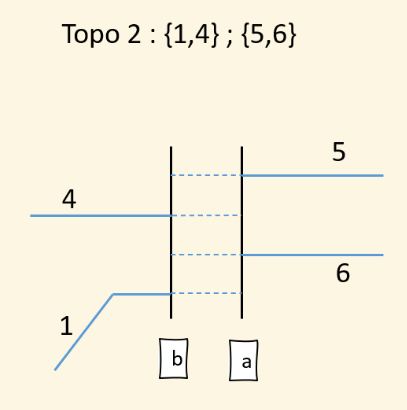
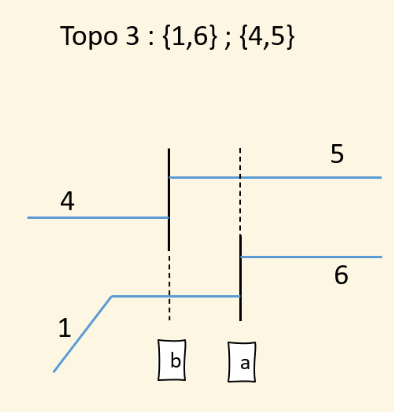
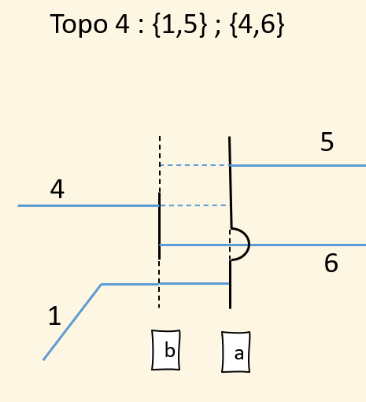

### Score Function

The goal is to control electricity transportation in power networks, while pursuing multiple objectives: balancing production and consumption, minimizing energetic losses, and keeping people and equipment safe which means to avoid catastrophic failures.

In order to be "valid" a topology must also ensure some physical constraints. One noteworthy restriction is that having a load alone without having any powerline connected to it is equivalent to disconnect it, and will lead to a *game over* since the agent will have disconnected a house/factory/hospital when they need electricity.

A score function is used to evaluate agents. It is the average of these three cost functions over the test scenarios:
* Cost of energy losses: Calculated by multiplying the amount of electricity lost due to the Joule effect by the current price of the MWh.
* Cost of operation: Sum of the costs of the agent’s actions. Operations involving changes in the production of electricity have a cost that depends on the energy market. The use of batteries has a fixed cost per MWh.
* Cost of blackout: If the agent did not manage the power network until the end of the scenario, this cost is calculated by multiplying the amount of electricity left to supply by the current price of MWh.

The score function is normalized so that it is to be maximized and is between the bounds [−100, 100]. A score of 0 corresponds to an agent that does nothing at each time
step. Having a positive score is already pretty good.

A closely correlated concept is **Reward**, or the feedback received by the agent for its previous action. It is the reward that defines the objectives of the agent (the goal of the agent is to maximize the reward it receives over time). The Reward of an agent depends on its policy, and in whichever way the reward function manifects itself, it should closely correlate with the score function. 

We will download all the packages that might be necessary, which are recorded in packages.txt

In [4]:
#pip install -r packages.txt

## Get the Data
Once grid2op is installed, we can get the competition data (approximately 2.0Gb) directly from the internet. training dataset which is what we will download. It contains 32 years of data, with 52 weeks in each each year, 7 days in each week and 288 steps in each day. 

In [14]:
from tqdm.notebook import tqdm  # for easy progress bar
from lightsim2grid import LightSimBackend # for faster simulations
from grid2op.Reward import GameplayReward, EconomicReward, LinesCapacityReward, CombinedScaledReward, RedispReward

# Get the competition environment
env = grid2op.make("l2rpn_wcci_2022", backend=LightSimBackend(), test=False, reward_class=CombinedScaledReward) 

As score is composed of 3 components, we experimented with a few combinations of rewards, and settled with the combination below.

In [17]:
# Define the reward function
cr = env.get_reward_instance() 

# Reward for making a legal move (different than game ending; the agent does nothing instead)
cr.addReward("Gameplay", GameplayReward(), 1.0)  
# Reward for minimizing the marginal cost of the powergrid
cr.addReward("Economic", EconomicReward(), 1.0)
# Reward based on the capacity usage of the grid
cr.addReward("Capacity", LinesCapacityReward(), 2.0)
# Reward for redispatching actions
cr.addReward("Redispatching", RedispReward(), 1.0)

cr.initialize(env)

## Inspect the Powergrid

Let's take a look at the grid that we will be running our RL agent on.

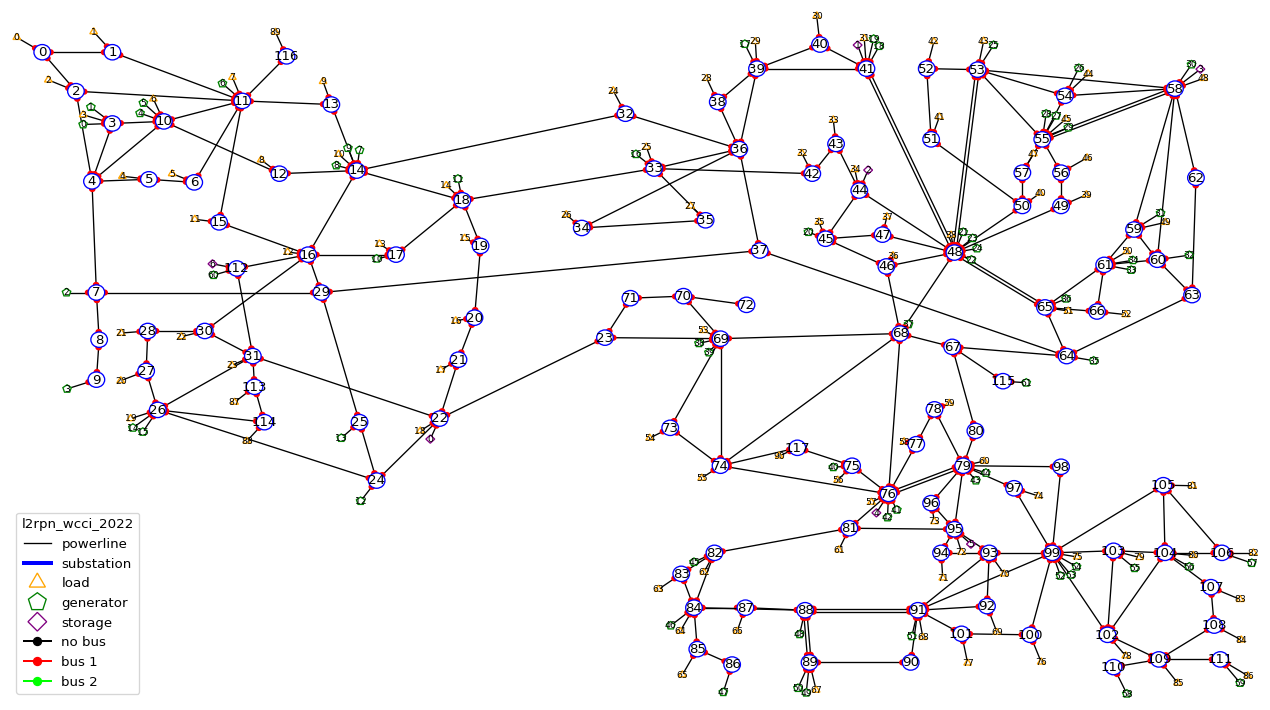

In [18]:
plot = PlotMatplot(env.observation_space)
fig = plot.plot_layout()

It seems much more complex than the previous one, and the number of possible action has exponentially increased.

In [19]:
import numpy as np 
from grid2op.gym_compat import GymEnv, MultiDiscreteActSpace, BoxGymObsSpace

gym_env = GymEnv(env)

dim_act_space = np.sum([np.sum(gym_env.action_space[el].shape) for el in gym_env.action_space.spaces])
print(f"The size of the action space is : "
      f"{dim_act_space}")
dim_obs_space = np.sum([np.sum(gym_env.observation_space[el].shape).astype(int) 
                        for el in gym_env.observation_space.spaces])
print(f"The size of the observation space is : "
      f"{dim_obs_space}")

The size of the action space is : 1567
The size of the observation space is : 5007


As some actions are duplicated (e.g. switching the bus of one node is equivalent to directly setting it to a specific value), we can restrict ourselves to a subset of them. Similarly, in the observation space, not all the variables are relevant to our target. 

In [20]:
keep_obs = ["day_of_week", "hour_of_day", "minute_of_hour", "prod_p", "prod_v", "load_p", "load_q",
    "actual_dispatch", "target_dispatch", "topo_vect", "time_before_cooldown_line",
    "time_before_cooldown_sub", "rho", "timestep_overflow", "line_status",
    "storage_power", "storage_charge"]
keep_act = ['curtail', 'redispatch',
    # 'set_bus', # Leads to too many game overs
    'sub_set_bus', # Change a whole substation each time instead
    'set_line_status', 'set_storage']

# Grid2op provides some utility functions to make their environment Gym-compatible
gym_env.observation_space =  BoxGymObsSpace(env.observation_space,keep_obs)
gym_env.action_space = MultiDiscreteActSpace(env.action_space, keep_act)

## Test Case 1: Create a Do-Nothing Agent
Now we have our environment setup, let's create our first reinforcement learning agent. We will start with an agent that does nothing to test out if everything works.

In [21]:
from grid2op.Agent import DoNothingAgent #Grid2op has a do-nothing agent we can test with.

my_agent = DoNothingAgent(env.action_space)

We will run through the standarm gym loop and record the observations.

In [22]:
# Initialize an empty list to store all the observations.
all_obs = []

# Reset the environment and get the initial observation.
obs = env.reset()

# Add the initial observation to the list of all observations.
all_obs.append(obs)

# Set the initial reward to the minimum possible reward.
reward = env.reward_range[0]

# Set the done flag to False, indicating that the episode is not over.
done = False

# Initialize the step counter to 0.
nb_step = 0

# Use tqdm to create a progress bar.
with tqdm(total=env.chronics_handler.max_timestep(), disable=True) as pbar:
    # Loop until the episode is over
    while True:
        # Ask the agent to choose an action (do nothing, in this case) based on the current observation, reward, and done flag
        action = my_agent.act(obs, reward, done)

        # Take a step with the chosen action and get the new observation, reward, and done flag
        obs, reward, done, _ = env.step(action)

        pbar.update(1)

        # If the episode is over, break out of the loop.
        if done:
            break

        all_obs.append(obs)
        nb_step += 1

print("Number of timesteps computed: {}".format(nb_step))
print("Total maximum number of timesteps possible: {}".format(env.chronics_handler.max_timestep()))

Number of timesteps computed: 229
Total maximum number of timesteps possible: 2017


The agent successfully managed to run the network 229 timesteps, while the episode could have lasted 2017. Therefore, there has been a "game over".

We can investigate how the agent failed by plotting the last observation:

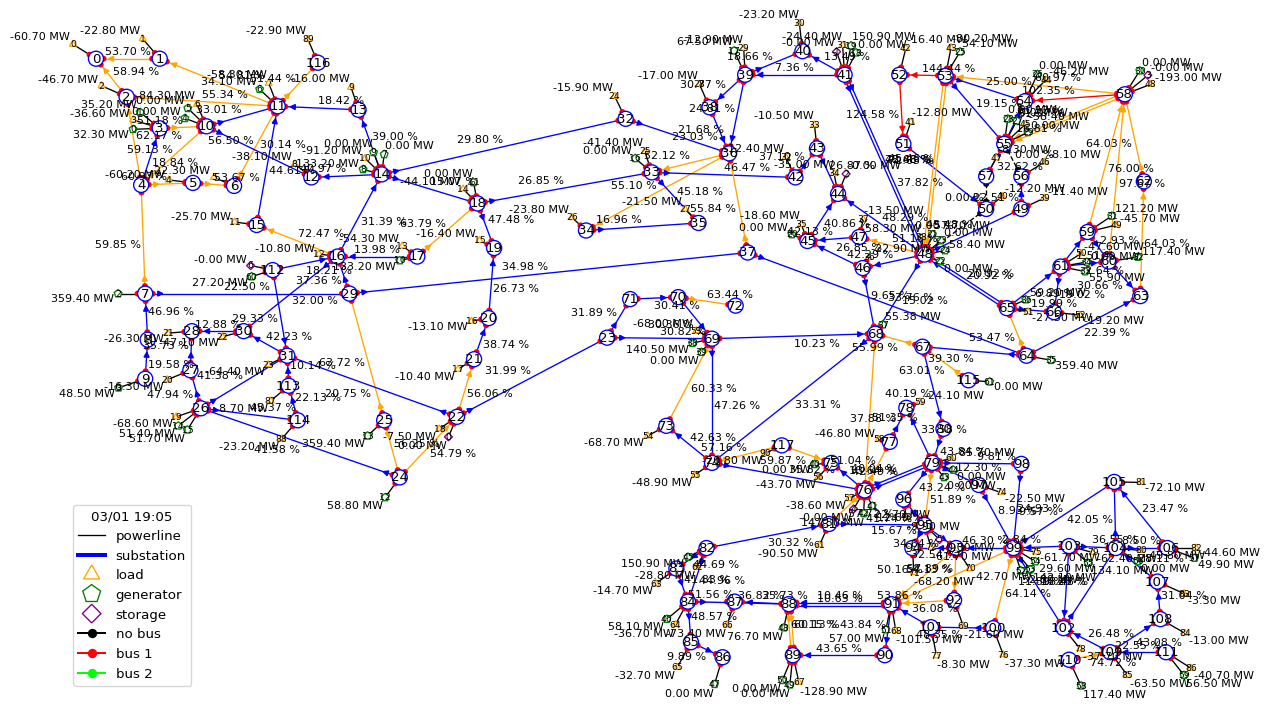

In [23]:
last_obs = all_obs[-1]
fig = plot.plot_obs(last_obs)

Seems like the powerlines connecting substation 52 are overloaded, thus disconnecting the load (electrcity-using entities such as buildings) attached.

## Test Case 2 : DQN from scratch

Let's first try a basic approach and see how well it performs compared to the Do Nothing agent.

In [10]:
from dqn import *

state_size = gym_env.observation_space.shape[0]
action_size = gym_env.action_space.nvec.sum()
agent = DQNAgent(gym_env, state_size, 100, gym_env.action_space.nvec)
agent.train(episodes=1000)

Chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288
chronics at: 2050-02-14_0	total score: -10.000000	time steps: 1/288


Unfortunately, it does not work very well in comparison to the do-nothing agent. This is is likely due to the fact that powergrid is fragile and sensitive; any action will likely bring a game over. Our DQN agent did not manage to learn how to do valid actions without breaking the grid, since exploring by sampling is too inefficient and any random action is likely to be illegal. During the competition, many of the successful submissions used some heuristic to guide the actions; for example, doing nothing until the grid approaches a dangerous state.

## Test Case 3: Double Dueling DQN
The competition package includes a Double Dueling DQN agent, which combines Double Q-learning and Dueling architecture. Double Q-learning reduces Q-value overestimation using two Q-value functions. During training, one function is randomly selected to update parameters while the other evaluates Q-values. Dueling architecture separates the value and advantage functions of the Q-value function, enabling more efficient learning of action values in different states.
Let's test it out!

In [13]:
from l2rpn_baselines.DoubleDuelingDQN import train as DDDQN_train
from l2rpn_baselines.DoubleDuelingDQN import evaluate as DDDQN_evaluate

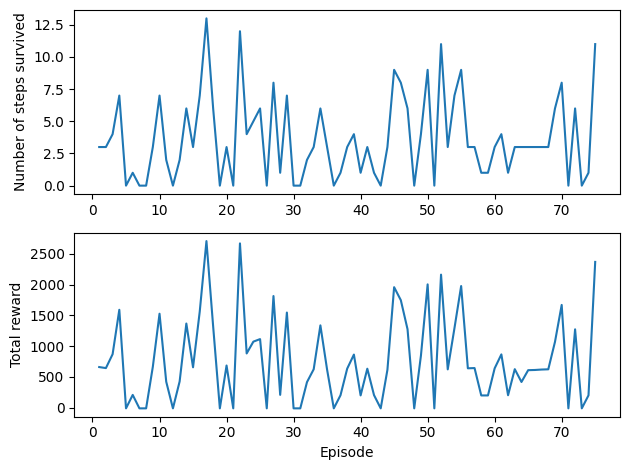

In [30]:
# Train the DQN agent
agent = DDDQN_train(env, name="DoubleDuelingDQN", save_path="DDDQN", iterations=100)

D3QN performs relatively well, although it looks like the agent did not survive for a very long time. Also, from the graph it is clear that the number of steps survived and the total reward are highly correlated.

In [11]:
# Let's take a more detailed look at the results

res = DDDQN_evaluate(
  env,
  load_path="DDDQN/DoubleDuelingDQN.h5",
  nb_episode=10
)

for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  print(msg_tmp)



Evaluation summary:
chronics at: 2050-01-03_0	total reward: 49632.574219	time steps: 233/2017
chronics at: 2050-01-03_1	total reward: 49871.144531	time steps: 230/2017
chronics at: 2050-01-03_10	total reward: 35988.394531	time steps: 156/2017
chronics at: 2050-01-03_11	total reward: 644.348999	time steps: 4/2017
chronics at: 2050-01-03_12	total reward: 36007.460938	time steps: 159/2017
chronics at: 2050-01-03_13	total reward: 47933.054688	time steps: 222/2017
chronics at: 2050-01-03_14	total reward: 32313.970703	time steps: 141/2017
chronics at: 2050-01-03_15	total reward: 32388.773438	time steps: 142/2017
chronics at: 2050-01-03_16	total reward: 4624.027832	time steps: 21/2017
chronics at: 2050-01-03_17	total reward: 21747.671875	time steps: 87/2017
chronics at: 2050-01-03_0	total score: 49632.574219	time steps: 233/2017
chronics at: 2050-01-03_1	total score: 49871.144531	time steps: 230/2017
chronics at: 2050-01-03_10	total score: 35988.394531	time steps: 156/2017
chronics at: 2050

## Test Case 4: PPO

Next, let's try the PPO (Proximal Policy Optimization) which has the benefit of being more sample-efficient than other RL algorithms, thus enabling it to learn a good policy with fewer training samples. To our benefit, the competition package includes a PPO agent with stable-baseline 3. Let's use it to test out its performance.

In [10]:
#pip install l2rpn-baselines
#pip install stable-baselines3

In [15]:
from l2rpn_baselines.PPO_SB3 import train as ppo_train
from l2rpn_baselines.PPO_SB3 import evaluate as ppo_evaluate

In [ ]:
# Train the PPO agent using the environment

def linear_schedule(final_value: float) :
    """
    Linear learning rate schedule.

    :param final_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return min(1, (1-progress_remaining)*4) * final_value
    return func

n_steps = 256
num_exp = 1
agent = ppo_train(
    env, 
    name=f"PPO_SB3_{num_exp}", 
    save_path="PPO_SB3",
    # load_path=f"PPO_SB3/PPO_SB3_{num_exp}", 
    logs_dir="logs", 
    n_steps=n_steps,
    iterations=n_steps*100, # 100 iterations (with 10 epochs / iter)
    act_attr_to_keep=keep_act,
    obs_attr_to_keep=keep_obs,
    learning_rate=linear_schedule(1e-5),
    model_policy="MlpPolicy",
    policy_kwargs={
        "net_arch": [100, 100, 100]
    }
)

Evaluate the stable-baseline model.

In [37]:
g2op_agent, res = ppo_evaluate(
                            env,
                            load_path="PPO_SB3/",
                            name="PPO_SB3_1",
                            nb_episode=10,
                            obs_space_kwargs={},
                            act_space_kwargs={}
                          )
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
  msg_tmp = "chronics at: {}".format(chron_name)
  msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
  msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
  print(msg_tmp)

chronics at: 2050-01-03_0	total score: 45156.238281	time steps: 223/2017
chronics at: 2050-01-03_1	total score: 32919.730469	time steps: 152/2017
chronics at: 2050-01-03_10	total score: -10.000000	time steps: 1/2017
chronics at: 2050-01-03_11	total score: -10.000000	time steps: 1/2017
chronics at: 2050-01-03_12	total score: -10.000000	time steps: 1/2017
chronics at: 2050-01-03_13	total score: 32086.267578	time steps: 147/2017
chronics at: 2050-01-03_14	total score: -10.000000	time steps: 1/2017
chronics at: 2050-01-03_15	total score: 30347.373047	time steps: 136/2017
chronics at: 2050-01-03_16	total score: -10.000000	time steps: 1/2017
chronics at: 2050-01-03_17	total score: 8594.604492	time steps: 37/2017


Without hyper-parameter tuning the PPO model's performance is abysmal. The agent fails quickly in each scenario, which is likely due to the number of actions in the action space that would immediately lead to a game over.

## Test Case 4 (1): PPO with RAY

In [ ]:
# pip install jsonpickle

In [5]:
# import necessary libraries
import re
from grid2op.Reward import LinesCapacityReward  # or any other rewards
from grid2op.Chronics import MultifolderWithCache  # highly recommended
from lightsim2grid import LightSimBackend  # we will use this backend for training
import ray
from l2rpn_baselines.PPO_RLLIB import train, evaluate

In [ ]:
# initialize ray for distributed computing
ray.init()

# define environment name and initialize it
env_name="l2rpn_wcci_2022"
env = grid2op.make(env_name, backend=LightSimBackend())

try:
    # train an Agent with PPO RL algorithm using grid2op environment and save weights to file
    trained_agent = train(
        env,
        iterations=10,  # number of iterations to train the agent
        save_path="./saved_model",  # directory to save the trained NN weights
        name="test",  # name of the baseline
        net_arch=[100, 100, 100],  # architecture of the neural network
        save_every_xxx_steps=2,  # save the NN every 2 training steps
        env_kwargs={
            "reward_class": LinesCapacityReward,  # use LinesCapacityReward as the reward function
            "chronics_class": MultifolderWithCache,  # highly recommended
            "data_feeding_kwargs": {
                "filter_func": lambda x: True
            }
        },
        verbose=True  # print out information while training
    )
finally:
    # close the environment and ray after training is completed
    env.close()
    ray.shutdown()

## Future Work



During the implementation, we encountered a range of difficulties that fall into two broad categories: 
1. The large number of illegal actions (those that will immediately lead to game over) in the action space make it very difficult for any agent to make it very far in its exploration of the state space. To alleviate this, we intend to see if we can either try out some curriculum learning or transfer learning.
2. The development of RL resources is far less mature than that of supervised learning, creating significant obstacles during implementation. (For example, we attempted to implement AlphaZero to the given environment, but we were unable to implement suitable solutions during the time given.) In the future, we wish to apply AlphaZero to the problem and explore whether it can overcome power grid volatility. 
